<a href="https://colab.research.google.com/github/PSYcoms/Automatic-Number-Plate-Recognition/blob/main/ANPR_YOLOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# License Plate Detection using YOLOv3
YOLO abbreviates to You Only Look Once depicting its ability to detect objects and entities by using CNN (Convolutional Neural Network).Neural Network in YOLO uses weights trained by us through annotated training data by using bounding boxes. Hence YOLO takes an image as input puts it through a Neural Network and gives the output in the image through bounding boxes.

## Importing necessary libraries

In [ ]:
from IPython.display import Image
from matplotlib import pyplot as plt

import cv2
import argparse
import sys
import numpy as np
import pandas as pd
import os.path

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### To manually test images, simply add the path of the image in the input_path variable.

In [ ]:
#Enter path for the image to be tested
input_path = '/content/drive/MyDrive/test_dataset/images/14.jpg'

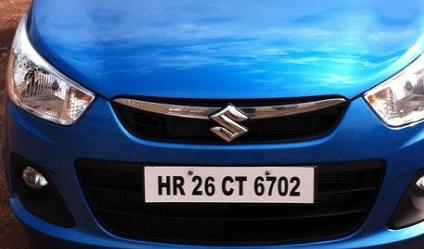

In [ ]:
Image(input_path)

## Input Receiver

In [ ]:
#Open the image file
cap = cv2.VideoCapture(input_path)

## YOLO Plate Detection
### Initialize the parameters

In [ ]:
# Initialized the parameters

confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4  #Non-maximum suppression threshold

inpWidth = 416     #Width of network's input image
inpHeight = 416     #Height of network's input image

In [ ]:
# Loaded names of classes
classesFile = "/content/drive/MyDrive/yolo_utils/classes.names";

In [ ]:
# Appended all different classes into the list 'classes'
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [ ]:
# Gave the configuration and weight files for the model and loaded the network using them.
modelConfiguration = "/content/drive/MyDrive/yolo_utils/yolov3_testing.cfg";
modelWeights = "/content/drive/MyDrive/yolo_utils/new_yolov3_training_last.weights";

After importing the config and weights file, we set up the model using ```cv2.dnn.readNetFromDarknet()``` function.

In [ ]:
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


### Define the post processing functions

In [ ]:
def getOutputsNames(net):
    #Names of all the layers in the network
    layersNames = net.getLayerNames()
    # Names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

The following function ```drawPred()``` draws a bounding box in an image when attributes like class name, confidence, coordinates and the image itself is passed though it.

In [ ]:
# Drawing the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom, frame):
    # Drawing a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Displaying the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left +round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
    #cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

In [ ]:
# Removing the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    
    
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        #print("out.shape : ", out.shape)
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            '''if detection[4]>confThreshold:
                print(detection[4], " - ", scores[classId],"-th:" confThreshold)
                print(detection)'''
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Performing non maximum suppression to eliminate redundant overlapping boxes with lower confidences.
    cropped=None
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        #i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        
        # calculate bottom and right
        bottom = top + height
        right = left + width
        
        #crop the plate out
        cropped = frame[top:bottom, left:right].copy()
        # drawPred
        drawPred(classIds[i], confidences[i], left, top, right, bottom, frame)
    if cropped is not None:
        return cropped

### Plate Detection
We first create a 4D blob from the image, set input to the network, run the forward pass to get output of the output layers and send the image to the function ```postprocess()``` to remove low confidence boxes and draw the predicted box.

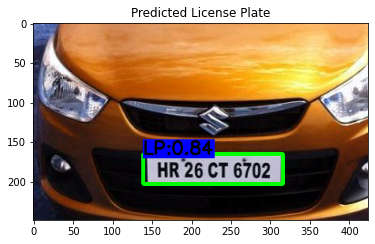

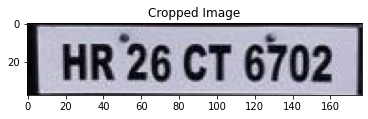

Done processing !!!


In [ ]:
while cv2.waitKey(1) < 0:

    hasFrame, frame = cap.read() #frame: an image object from cv2

    # Stop the program if reached end of video
    if not hasFrame:
        print("Done processing !!!")
        break

    # Create a 4D blob from a frame.
    blob=cv2.dnn.blobFromImage(frame,1/255,(inpWidth,inpHeight),[0,0,0],1,crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    cropped = postprocess(frame, outs)

    plt.imshow(frame)
    plt.title("Predicted License Plate")
    plt.show()
    plt.imshow(cropped)
    plt.title("Cropped Image")
    plt.show()

## Character Segmentation
Character segmentation is an operation that seeks to decompose an image of a sequence of characters into subimages of individual symbols. It is one of the decision processes in a system for optical character recognition (OCR).

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

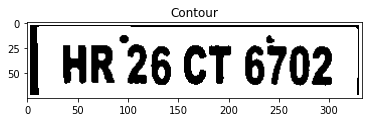

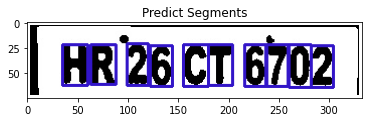

In [ ]:
char=segment_characters(cropped)

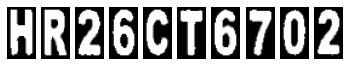

In [ ]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

## Character Recognition using CNN


In [ ]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('/content/drive/MyDrive/cc3/my_checkpoint')

## Predict the license plate number


In [ ]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = loaded_model.predict(img)[0]#predicting the class
        for j in range(36):
          if y_[j]>0.9:
            character = dic[j]
            output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    return plate_number

print(show_results())

1/1 [==============================] - 0s 31ms/step
HR26CT6702


1/1 [==============================] - 0s 33ms/step


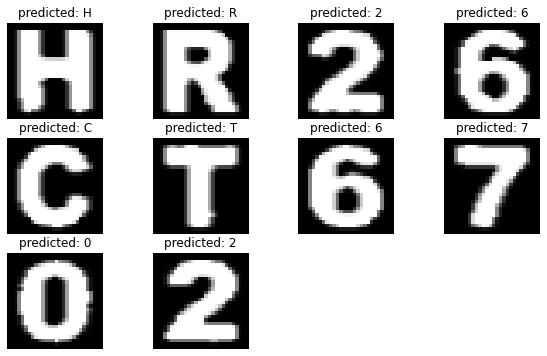

In [ ]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

## Importing the dataset
We have imported our dataset to calculate the overall accuracy of this method. The dataset contains about 110 images with a labels.xlsx that will be useful to check if the predicted output is correct.

In [ ]:
labels=pd.read_excel('/content/drive/MyDrive/test_dataset/labels.xlsx')
labels['ID']=labels['ID'].map(str)
labels

,ID,NUMBER
0,1,KL55R2473
1,2,BAV9R93
2,3,KL16J3636
3,4,GAR1P11
4,5,PJJ1L76
...,...,...
181,182,DHF5B15
182,183,DBJ5R59
183,184,LVY8X45
184,185,YYD6B61


## Accuracy


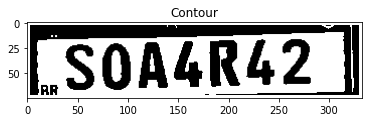

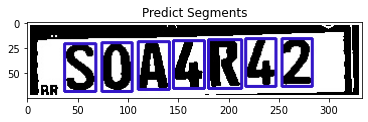

1/1 [==============================] - 0s 39ms/step
S0AARA2 S0A4R42


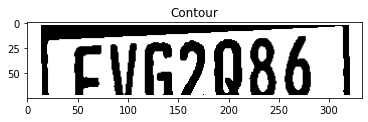

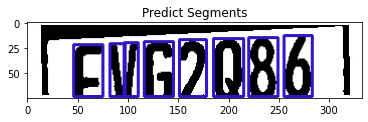

1/1 [==============================] - 0s 30ms/step
E1JR2D86 FVG2Q86


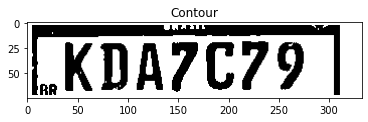

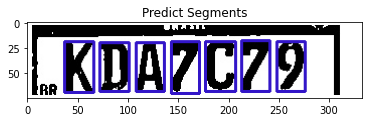

1/1 [==============================] - 0s 32ms/step
KDA7E79 KDA7C79


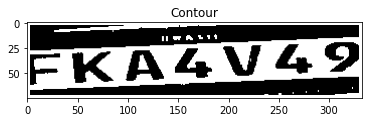

 FKA4V49


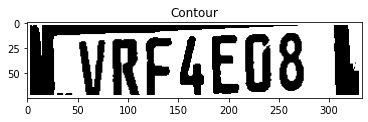

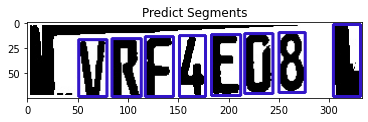

1/1 [==============================] - 0s 30ms/step
URFAED81 VRF4E08


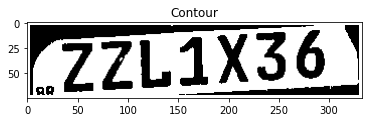

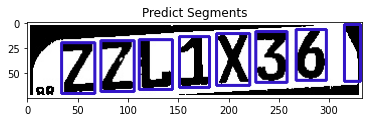

1/1 [==============================] - 0s 35ms/step
ZZL1X36N ZZL1X36


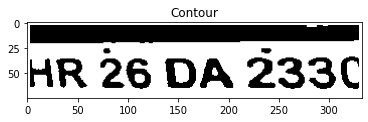

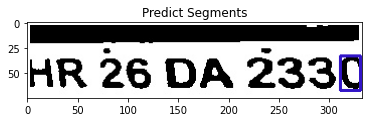

1/1 [==============================] - 0s 34ms/step
C HR26DA2330


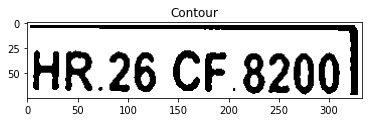

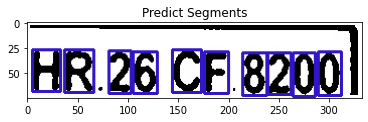

1/1 [==============================] - 0s 33ms/step
HR26CF8200 HR26CF8200


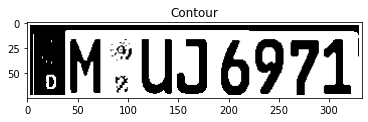

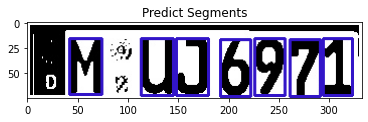

1/1 [==============================] - 0s 31ms/step
MUJ6971 MUJ6971


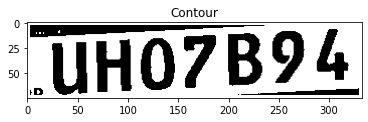

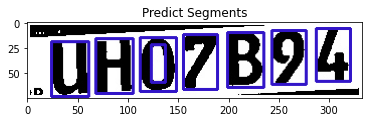

1/1 [==============================] - 0s 32ms/step
UH0T7B94 UH07B94


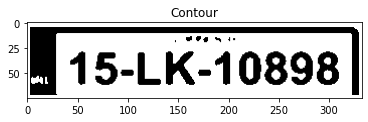

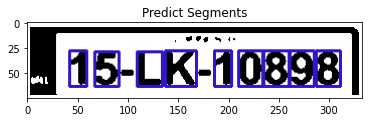

1/1 [==============================] - 0s 32ms/step
15LK10898 15LK10898


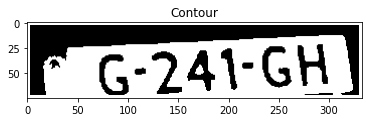

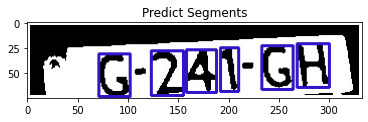

1/1 [==============================] - 0s 33ms/step
G241GH G241GH


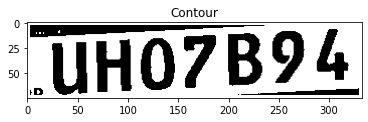

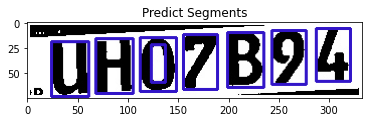

1/1 [==============================] - 0s 34ms/step
UH0T7B94 UH07B94


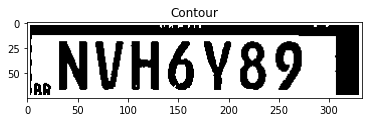

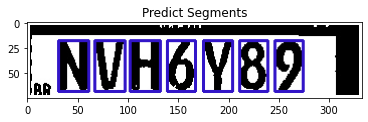

1/1 [==============================] - 0s 36ms/step
NVH6Y89 NVH6Y89


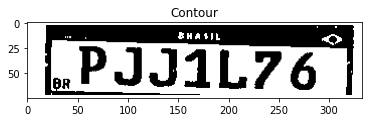

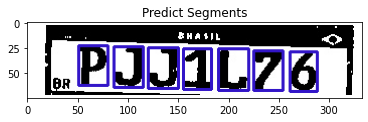

1/1 [==============================] - 0s 37ms/step
PJJ1L76 PJJ1L76


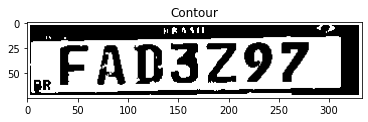

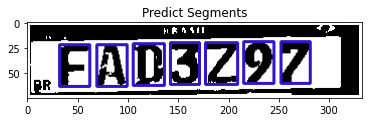

1/1 [==============================] - 0s 31ms/step
FAD3Z97 FAD3Z97


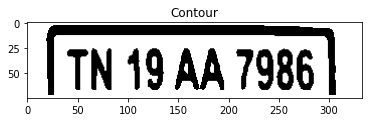

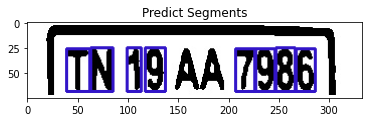

1/1 [==============================] - 0s 34ms/step
TN197986 TN19AA7986


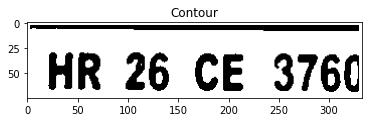

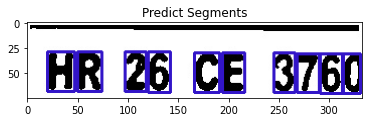

1/1 [==============================] - 0s 31ms/step
HR26CE376C HR26CE3760


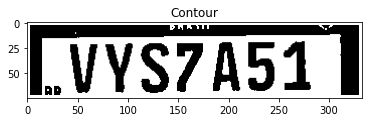

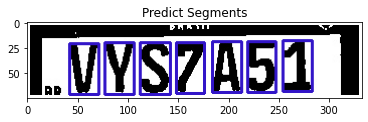

1/1 [==============================] - 0s 34ms/step
VYS7A51 VYS7A51


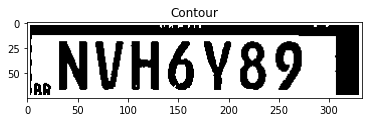

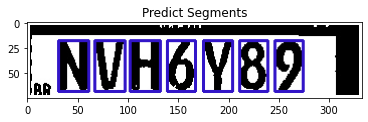

1/1 [==============================] - 0s 32ms/step
NVH6Y89 NVH6Y89


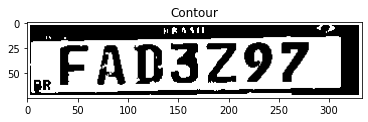

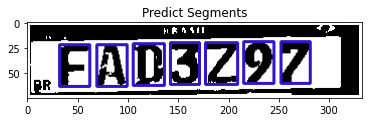

1/1 [==============================] - 0s 34ms/step
FAD3Z97 FAD3Z97


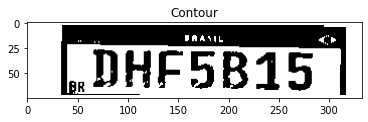

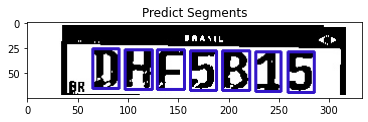

1/1 [==============================] - 0s 32ms/step
DHF5B15 DHF5B15


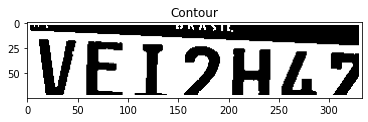

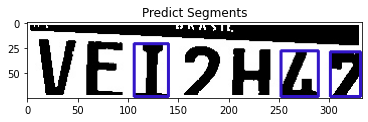

1/1 [==============================] - 0s 33ms/step
IA7 VEI2H47


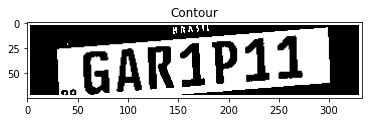

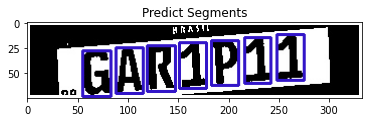

1/1 [==============================] - 0s 33ms/step
GAR1P11 GAR1P11


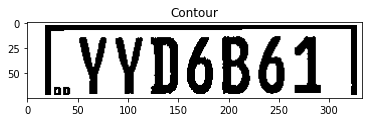

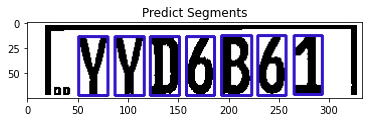

1/1 [==============================] - 0s 31ms/step
YYD6B61 YYD6B61


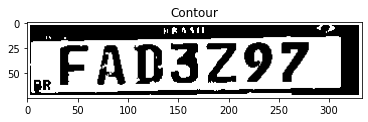

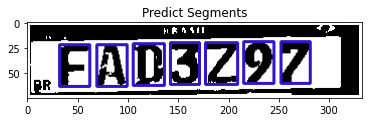

1/1 [==============================] - 0s 31ms/step
FAD3Z97 FAD3Z97


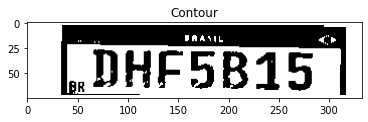

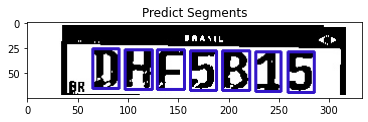

1/1 [==============================] - 0s 32ms/step
DHF5B15 DHF5B15


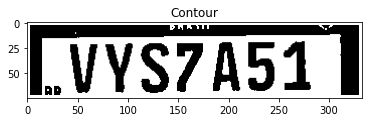

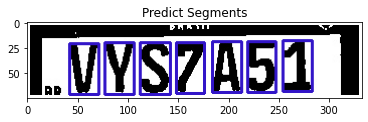

1/1 [==============================] - 0s 31ms/step
VYS7A51 VYS7A51


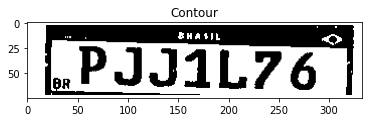

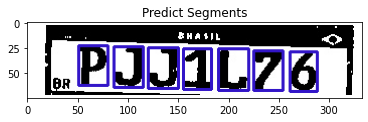

1/1 [==============================] - 0s 34ms/step
PJJ1L76 PJJ1L76


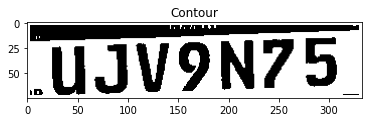

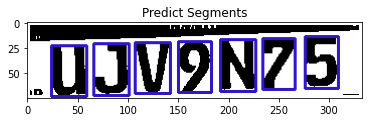

1/1 [==============================] - 0s 32ms/step
UJV9N75 UJV9N75


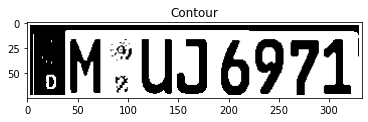

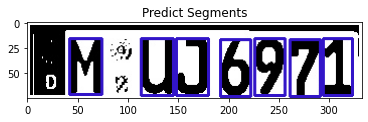

1/1 [==============================] - 0s 31ms/step
MUJ6971 MUJ6971


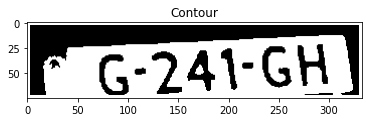

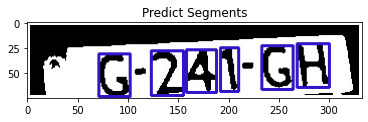

1/1 [==============================] - 0s 33ms/step
G241GH G241GH


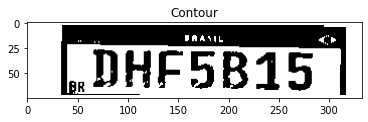

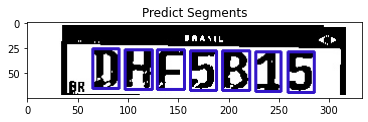

1/1 [==============================] - 0s 37ms/step
DHF5B15 DHF5B15


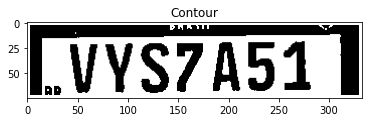

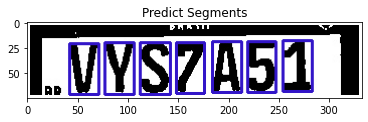

1/1 [==============================] - 0s 34ms/step
VYS7A51 VYS7A51


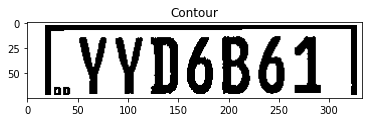

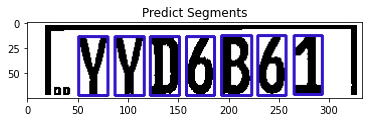

1/1 [==============================] - 0s 32ms/step
YYD6B61 YYD6B61


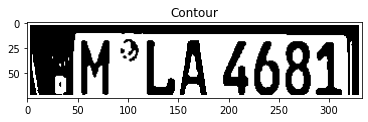

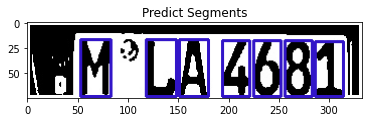

1/1 [==============================] - 0s 32ms/step
MLA4681 MLA4681


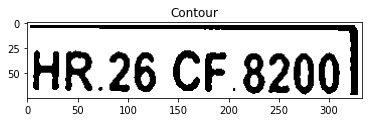

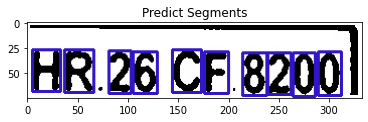

1/1 [==============================] - 0s 31ms/step
HR26CF8200 HR26CF8200


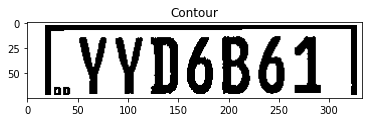

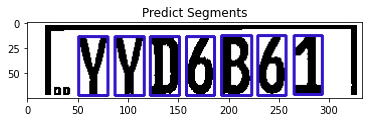

1/1 [==============================] - 0s 32ms/step
YYD6B61 YYD6B61


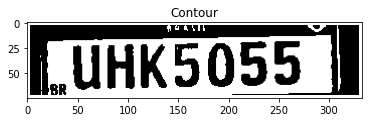

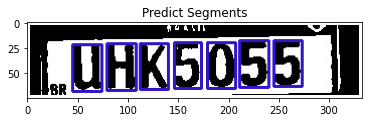

1/1 [==============================] - 0s 40ms/step
UHK5055 UHK5055


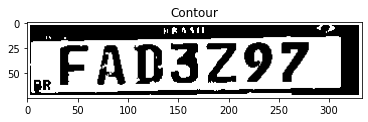

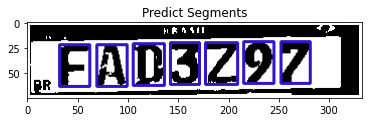

1/1 [==============================] - 0s 41ms/step
FAD3Z97 FAD3Z97


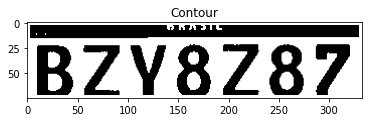

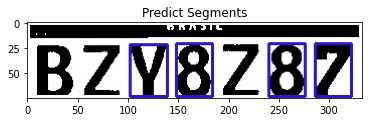

1/1 [==============================] - 0s 36ms/step
V887 BZY8Z87


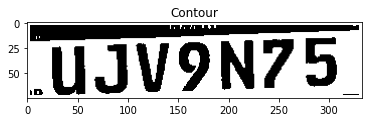

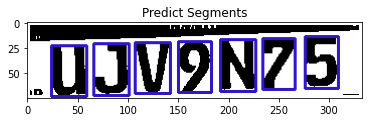

1/1 [==============================] - 0s 32ms/step
UJV9N75 UJV9N75


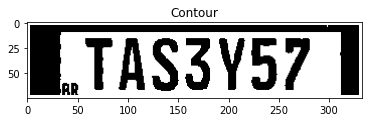

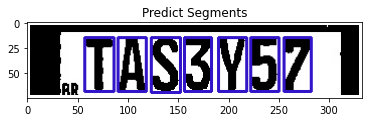

1/1 [==============================] - 0s 34ms/step
TAS3Y57 TAS3Y57


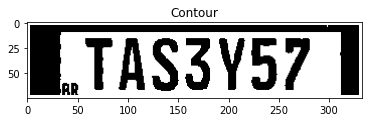

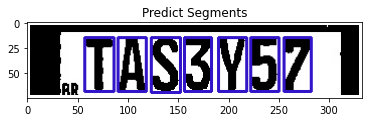

1/1 [==============================] - 0s 33ms/step
TAS3Y57 TAS3Y57


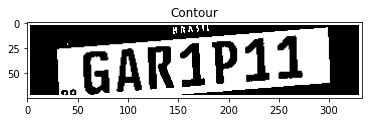

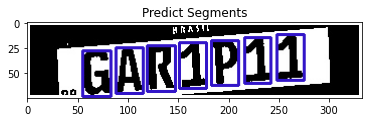

1/1 [==============================] - 0s 38ms/step
GAR1P11 GAR1P11


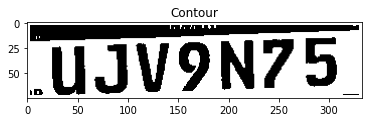

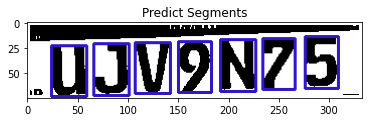

1/1 [==============================] - 0s 38ms/step
UJV9N75 UJV9N75


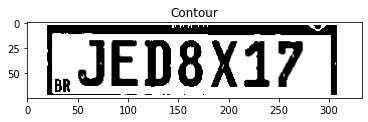

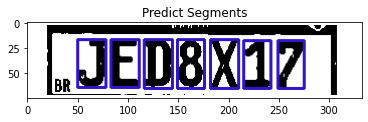

1/1 [==============================] - 0s 34ms/step
JED8X17 JED8X17


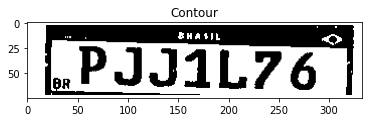

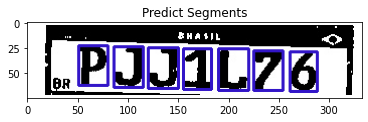

1/1 [==============================] - 0s 33ms/step
PJJ1L76 PJJ1L76


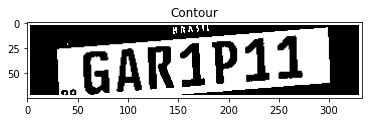

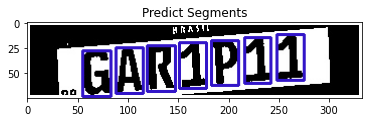

1/1 [==============================] - 0s 36ms/step
GAR1P11 GAR1P11


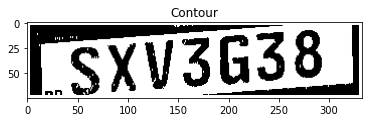

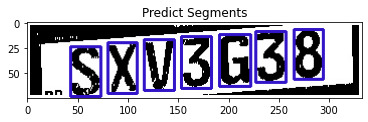

1/1 [==============================] - 0s 36ms/step
SXV3G38 SXV3G38


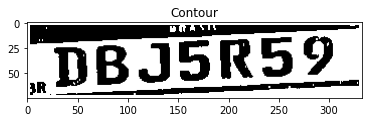

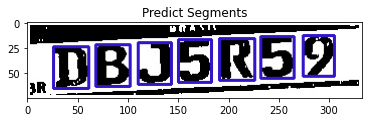

1/1 [==============================] - 0s 37ms/step
DBJ5R59 DBJ5R59


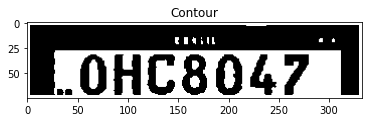

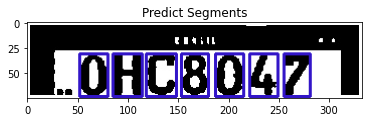

1/1 [==============================] - 0s 34ms/step
0H8047 0HC8047


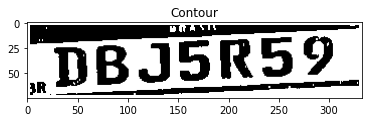

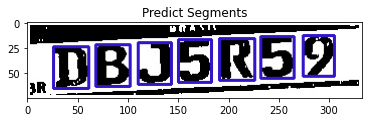

1/1 [==============================] - 0s 33ms/step
DBJ5R59 DBJ5R59


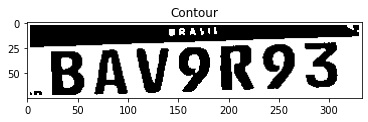

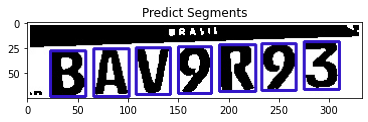

1/1 [==============================] - 0s 36ms/step
BAV9R93 BAV9R93


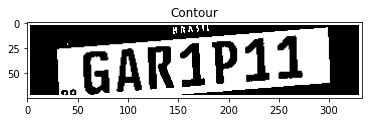

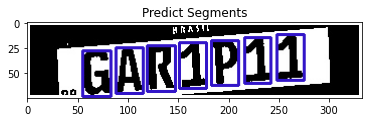

1/1 [==============================] - 0s 37ms/step
GAR1P11 GAR1P11


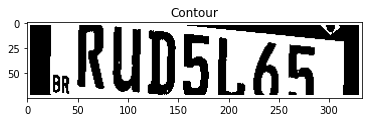

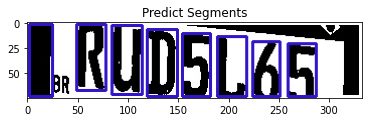

1/1 [==============================] - 0s 42ms/step
WRUD5LAR RUD5L65


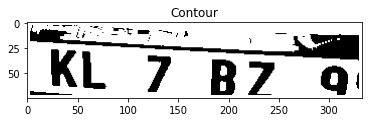

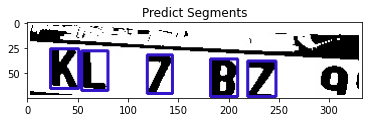

1/1 [==============================] - 0s 41ms/step
KL7B7 KL7BZ99


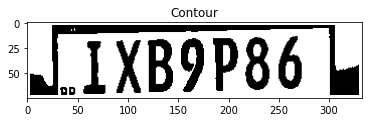

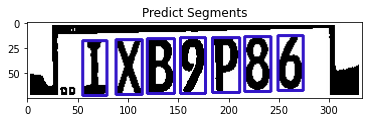

1/1 [==============================] - 0s 37ms/step
1XB9P86 IXB9P86


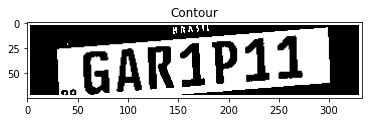

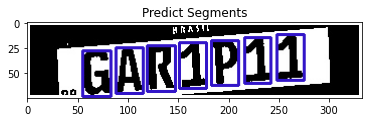

1/1 [==============================] - 0s 34ms/step
GAR1P11 GAR1P11


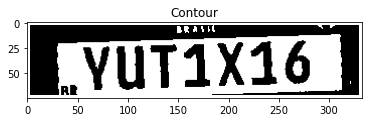

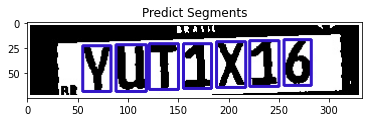

1/1 [==============================] - 0s 36ms/step
YUT1X16 YUT1X16


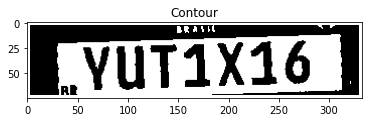

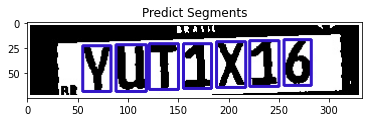

1/1 [==============================] - 0s 49ms/step
YUT1X16 YUT1X16


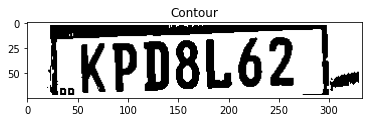

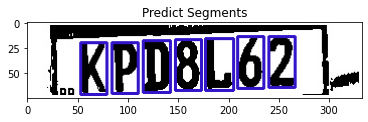

1/1 [==============================] - 0s 35ms/step
KPD8L62 KPD8L62


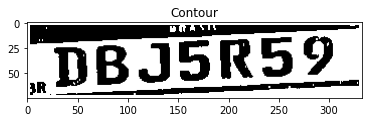

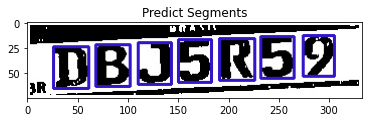

1/1 [==============================] - 0s 40ms/step
DBJ5R59 DBJ5R59


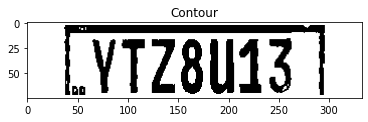

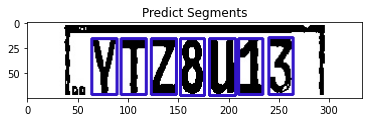

1/1 [==============================] - 0s 37ms/step
YTZ8U13 YTZ8U13


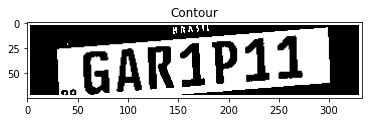

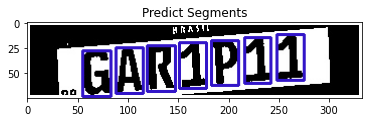

1/1 [==============================] - 0s 44ms/step
GAR1P11 GAR1P11


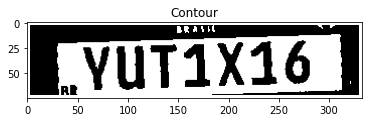

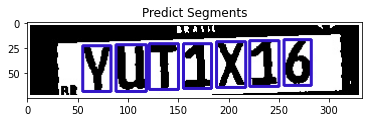

1/1 [==============================] - 0s 34ms/step
YUT1X16 YUT1X16


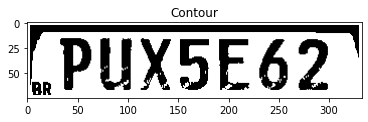

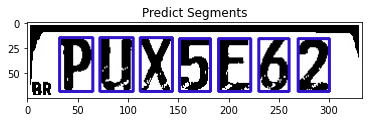

1/1 [==============================] - 0s 38ms/step
PUX5E62 PUX5E62


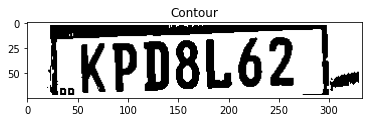

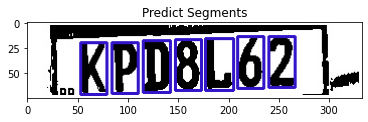

1/1 [==============================] - 0s 37ms/step
KPD8L62 KPD8L62


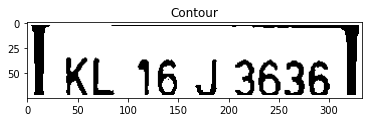

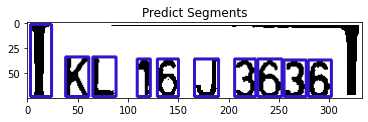

1/1 [==============================] - 0s 39ms/step
1KL16J3636 KL16J3636


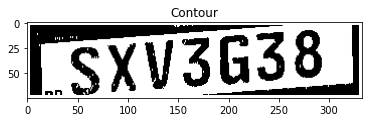

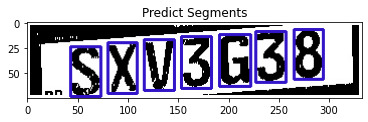

1/1 [==============================] - 0s 38ms/step
SXV3G38 SXV3G38


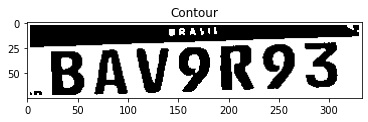

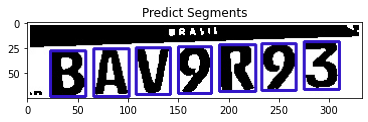

1/1 [==============================] - 0s 45ms/step
BAV9R93 BAV9R93


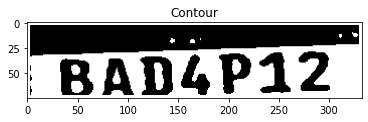

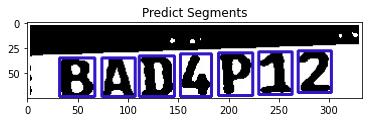

1/1 [==============================] - 0s 38ms/step
BADAP12 BAD4P12


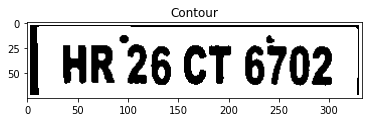

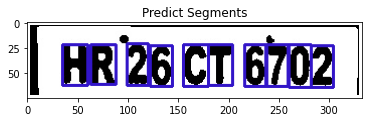

1/1 [==============================] - 0s 38ms/step
HR26CT6702 HR26CT6702


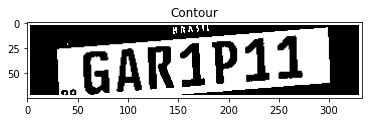

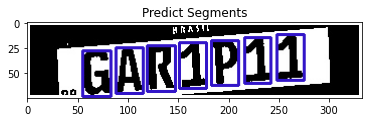

1/1 [==============================] - 0s 42ms/step
GAR1P11 GAR1P11


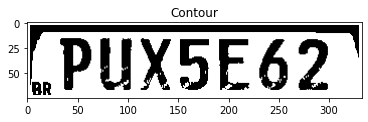

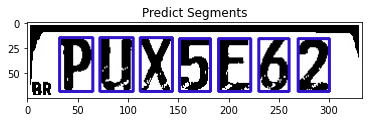

1/1 [==============================] - 0s 47ms/step
PUX5E62 PUX5E62


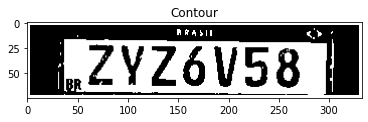

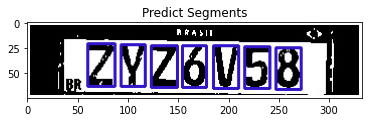

1/1 [==============================] - 0s 44ms/step
ZYZ6V58 ZYZ6V58


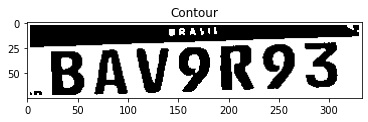

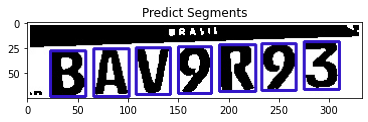

1/1 [==============================] - 0s 39ms/step
BAV9R93 BAV9R93


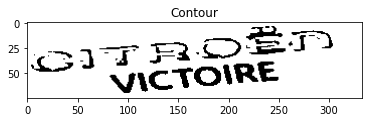

 LLZ6Y18


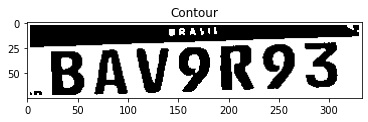

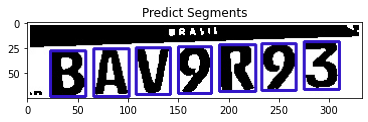

1/1 [==============================] - 0s 90ms/step
BAV9R93 BAV9R93


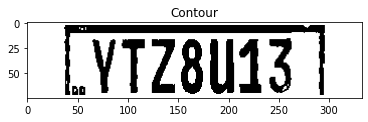

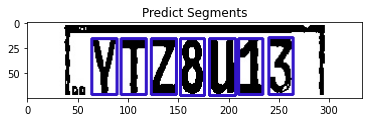

1/1 [==============================] - 0s 81ms/step
YTZ8U13 YTZ8U13


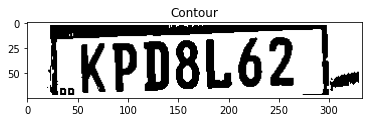

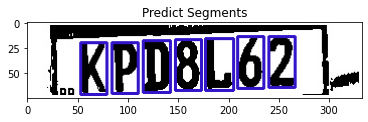

1/1 [==============================] - 0s 52ms/step
KPD8L62 KPD8L62


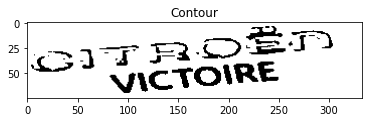

 LLZ6Y18


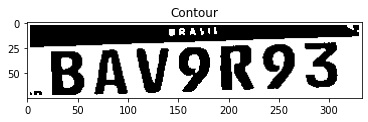

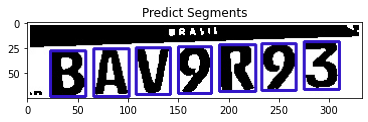

1/1 [==============================] - 0s 52ms/step
BAV9R93 BAV9R93


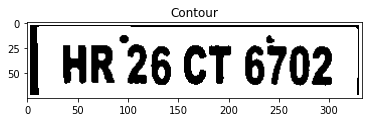

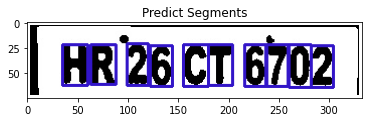

1/1 [==============================] - 0s 54ms/step
HR26CT6702 HR26CT6702


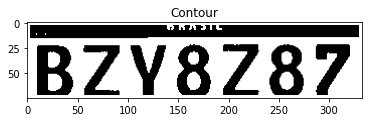

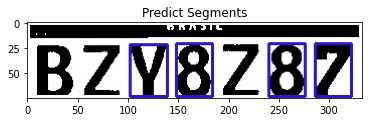

1/1 [==============================] - 0s 39ms/step
V887 BZY8Z87


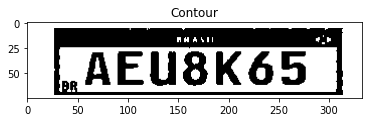

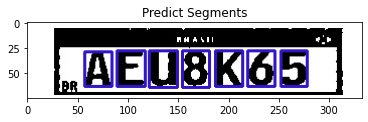

1/1 [==============================] - 0s 48ms/step
AEU8K65 AEU8K65


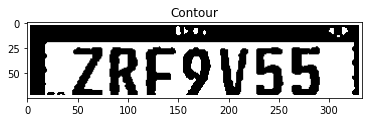

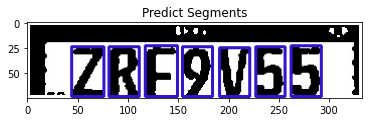

1/1 [==============================] - 0s 47ms/step
ZRF955 ZRF9V55


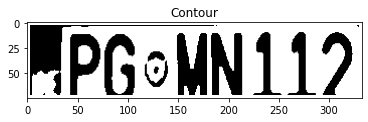

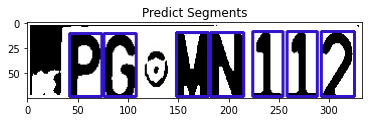

1/1 [==============================] - 0s 57ms/step
PGMN112 PGMN112


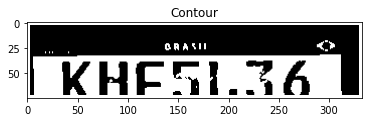

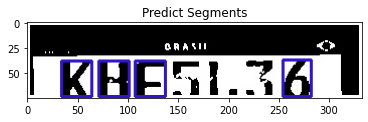

1/1 [==============================] - 0s 57ms/step
KHDA KHF5L36


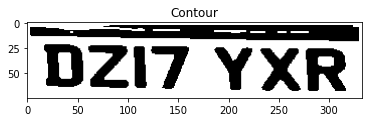

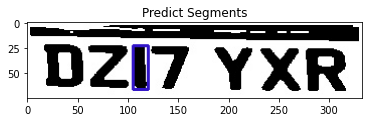

1/1 [==============================] - 0s 37ms/step
W DZ17YXR


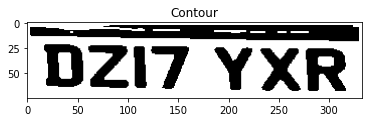

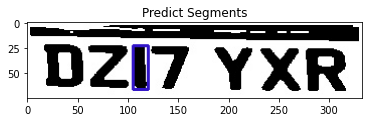

1/1 [==============================] - 0s 35ms/step
W DZ17YXR


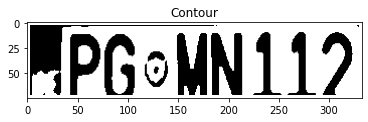

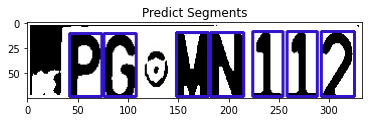

1/1 [==============================] - 0s 48ms/step
PGMN112 PGMN112


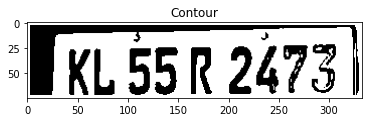

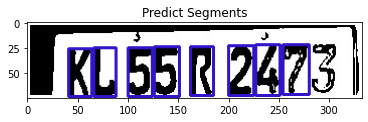

1/1 [==============================] - 0s 50ms/step
KL55R247 KL55R2473


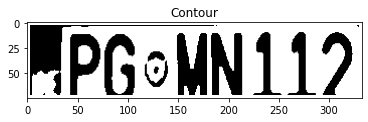

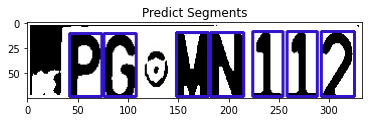

1/1 [==============================] - 0s 49ms/step
PGMN112 PGMN112


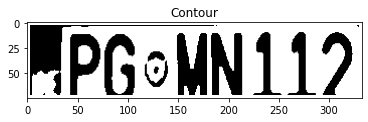

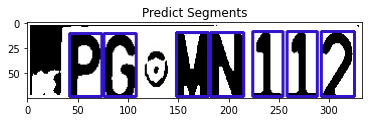

1/1 [==============================] - 0s 60ms/step
PGMN112 PGMN112


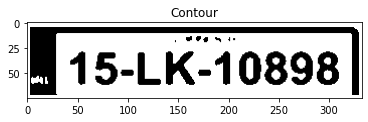

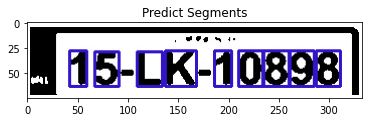

1/1 [==============================] - 0s 57ms/step
15LK10898 15LK10898


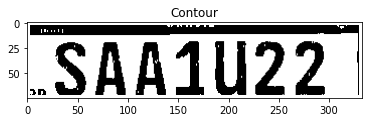

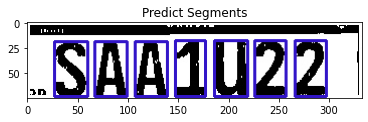

1/1 [==============================] - 0s 53ms/step
SAA1U22 SAA1U22


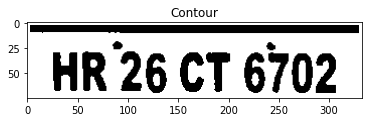

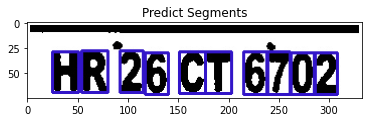

1/1 [==============================] - 0s 55ms/step
HR26CT6702 HR26CT6Y02


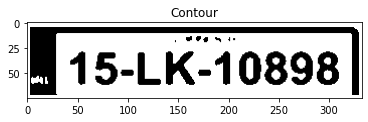

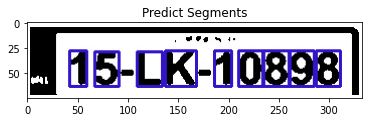

1/1 [==============================] - 0s 53ms/step
15LK10898 15LK10898


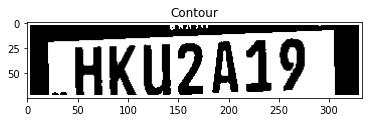

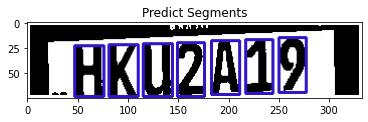

1/1 [==============================] - 0s 67ms/step
HKU2A19 HKU2A19


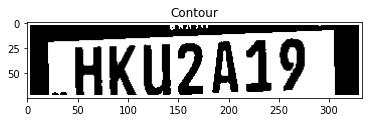

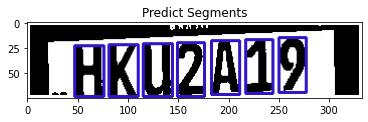

1/1 [==============================] - 0s 55ms/step
HKU2A19 HKU2A19


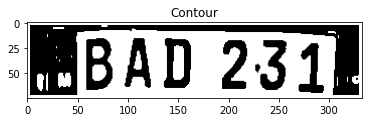

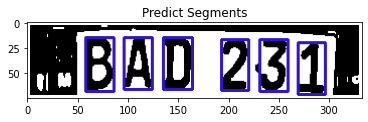

1/1 [==============================] - 0s 53ms/step
BAD231 BAD231


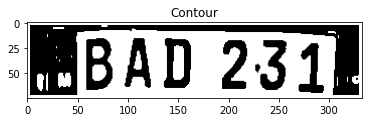

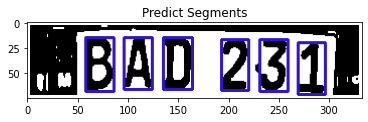

1/1 [==============================] - 0s 51ms/step
BAD231 BAD231


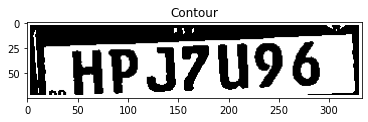

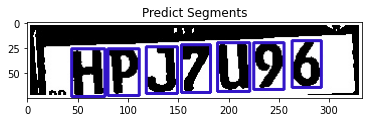

1/1 [==============================] - 0s 51ms/step
HPJ7U96 HPJ7U96


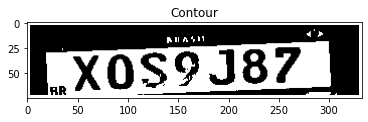

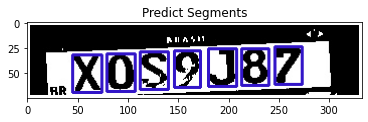

1/1 [==============================] - 0s 56ms/step
X0S9J87 X0S9J87
Accuracy: 70.0%


In [ ]:
file_list=os.listdir("/content/drive/MyDrive/test_dataset/images")
count=0
l=[]
for path in file_list:
#for entry in labels['ID']:
    input_path = '/content/drive/MyDrive/test_dataset/images/'+path
    is_video = False
    no=path[:-4]
    row=labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
    #print(row)
    
    cap = cv2.VideoCapture(input_path)
    
    outputFile = input_path + '_yolo_out_py.jpg'

    while cv2.waitKey(1) < 0:

        # get frame from the video
        hasFrame, frame = cap.read() #frame: an image object from cv2

        # Stop the program if reached end of video
        if not hasFrame:
            break

        # Create a 4D blob from a frame.
        try:
            blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
        except:
            break

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))

        # Remove the bounding boxes with low confidence
        cropped = postprocess(frame, outs)
        if cropped is not None:
            # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
            t, _ = net.getPerfProfile()
            label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
            
            char=segment_characters(cropped)
            # Predicting the output
            plate=show_results()
            print(plate,row)
            if plate==row:
              count+=1
print("Accuracy: "+str((count/110)*100)+"%")